## Lab 8:  Clustering
Environmental justice (EJ) seeks to ensure that all communities, regardless of socioeconomic status or demographic background, have equal access to clean air, water, and, in the form of energy justice, access to renewable energy resources while minimizing exposure to environmental hazards. In this lab, we will apply clustering analysis to explore how U.S. counties group together based on renewable energy potential, demographic characteristics, and environmental risk factors.

The EEIP dataset was collated by the National Renewable Energy Lab (NREL) and contains a large set of features from multiple other databases including SLOPE (renewable energy potential) and EJSCREEN (environmental risk indicators).

Link to metadata: https://ucsb.box.com/s/x3olvh3rd8w5h7xz8jnm3v8g3t4ajjsg

First you will step through a guided clustering exploration of renewable energy production potential.  Then you will formulate a question of your own that brings in an environmental justice component.


### Step 0: Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Load the EEIP dataset 
eeip_data = pd.read_csv("/courses/EDS232/Data/eeip.data.csv")

## Part I:
In this part, we will step through an analysis that examines how US counties cluster in their potential production of renewable energy.  

### Step 1: Exploratory Data Analysis

First we need to check for missing data and remove incomplete rows. Since clustering is a distance-based technique, we also need to ensure that the features used for clustering are scaled appropriately to prevent dominant features from skewing results.  For our first analysis, use the following variables from the SLOPE dataset related to energy production potential as your features: 
- `utility_pv_technical_generation_potential_mwh`
- `residential_pv_technical_generation_potential_mwh`
- `land_based_wind_technical_generation_potential_mwh`
- `commercial_pv_technical_generation_potential_mwh`

*Information on these variables is available on line 7 of the ColumnsExplained tab of the metadata*

Once you have removed incomplete rows and scaled, print the shape of your processed dataframe. 

In [2]:
pd.set_option('display.max_columns', None)

# Look at the data
eeip_data.head(5)

,county_fips,county,state,county_pop,utilitypv_techpot_quint,utility_pv_technical_generation_potential_mwh,residentialpv_techpot_quint,residential_pv_technical_generation_potential_mwh,landbasedwind_techpot_quint,land_based_wind_technical_generation_potential_mwh,commercialpv_techpot_quint,commercial_pv_technical_generation_potential_mwh,commercialpv_lcoe_cap_quint,commercial_pv_lcoe_capital_price_per_mw_median,commercialpv_lcoe_quint,commercial_pv_lcoe_price_per_mwh_median,geothermal_lcoe_cap_quint,geothermal_lcoe_capital_price_per_mw_median,geothermal_lcoe_quint,geothermal_lcoe_price_per_mwh_median,hydro_lcoe_cap_quint,hydro_lcoe_capital_price_per_mw_median,hydro_lcoe_quint,hydro_lcoe_price_per_mwh_median,landbasedwind_lcoe_cap_quint,land_based_wind_lcoe_capital_price_per_mw_median,landbasedwind_lcoe_quint,land_based_wind_lcoe_price_per_mwh_median,utilitypv_lcoe_cap_quint,pv_lcoe_capital_price_per_mw_median,utilitypv_lcoe_quint,pv_lcoe_price_per_mwh_median,residentialpv_lcoe_cap_quint,residential_pv_lcoe_capital_price_per_mw_median,residentialpv_lcoe_quint,residential_pv_lcoe_price_per_mwh_median,bev_growth_quint,hev_growth_quint,phev_growth_quint,icev_growth_quint,bev_prop_change,hev_prop_change,phev_prop_change,icev_prop_change,bev_2018_reference_vehicle_counts,bev_2050_reference_vehicle_counts,hev_gasoline_2018_reference_vehicle_counts,hev_gasoline_2050_reference_vehicle_counts,phev_2018_reference_vehicle_counts,phev_2050_reference_vehicle_counts,icev_gasoline_2018_reference_vehicle_counts,icev_gasoline_2050_reference_vehicle_counts,reopt_savings_quint,cost_savings_per_county,energyburden_indicator,energyburden_1_prop,energyburden_2_prop,energyburden_3_prop,energyburden_4_prop,unemployment_quint,unemprate2020,mining_quint,pctempmining,ruralurbancontinuumcode2013,type_2015_farming_no,type_2015_mining_no,population_loss_2015_update,perpov_1980_0711,minority_indicator,minority_pop_1_prop,minority_pop_2_prop,minority_pop_3_prop,minority_pop_4_prop,minority_pop_5_prop,lowincome_indicator,lowincome_pop_1_prop,lowincome_pop_2_prop,lowincome_pop_3_prop,lowincome_pop_4_prop,lowincome_pop_5_prop,lessthanhs_indicator,lessthanhs_pop_1_prop,lessthanhs_pop_2_prop,lessthanhs_pop_3_prop,lessthanhs_pop_4_prop,lessthanhs_pop_5_prop,pm25_indicator,pm25_1_prop,pm25_2_prop,pm25_3_prop,pm25_4_prop,pm25_5_prop,ozone_indicator,ozone_1_prop,ozone_2_prop,ozone_3_prop,ozone_4_prop,ozone_5_prop,leadpaint_indicator,leadpaint_1_prop,leadpaint_2_prop,leadpaint_3_prop,leadpaint_4_prop,leadpaint_5_prop,diesel_indicator,dieselparticulate_1_prop,dieselparticulate_2_prop,dieselparticulate_3_prop,dieselparticulate_4_prop,dieselparticulate_5_prop,cancer_indicator,cancerriskairtoxics_1_prop,cancerriskairtoxics_2_prop,cancerriskairtoxics_3_prop,cancerriskairtoxics_4_prop,cancerriskairtoxics_5_prop,respiratory_indicator,respiratoryhazardairtoxics_1_prop,respiratoryhazardairtoxics_2_prop,respiratoryhazardairtoxics_3_prop,respiratoryhazardairtoxics_4_prop,respiratoryhazardairtoxics_5_prop,traffic_indicator,trafficproxvol_1_prop,trafficproxvol_2_prop,trafficproxvol_3_prop,trafficproxvol_4_prop,trafficproxvol_5_prop,wastewater_indicator,wastewaterdischarge_1_prop,wastewaterdischarge_2_prop,wastewaterdischarge_3_prop,wastewaterdischarge_4_prop,wastewaterdischarge_5_prop,npl_indicator,nplprox_1_prop,nplprox_2_prop,nplprox_3_prop,nplprox_4_prop,nplprox_5_prop,rmp_indicator,rmpprox_1_prop,rmpprox_2_prop,rmpprox_3_prop,rmpprox_4_prop,rmpprox_5_prop,tsdf_indicator,tsdfprox_1_prop,tsdfprox_2_prop,tsdfprox_3_prop,tsdfprox_4_prop,tsdfprox_5_prop
0,1001,Autauga,AL,55200,3,3.585222e+07,4.0,122752.69,3,4374954.41,3.0,72863.02,NaN,NaN,2.0,66.302167,NaN,NaN,NaN,NaN,2.0,6532994.0,1.0,23.0,1.0,1530092.0,5.0,67.0,1.0,1085440.0,3.0,51.0,NaN,NaN,2.0,103.667192,4.0,2.0,2.0,4.0,0.036473,0.026496,0.005495,-0.068464,151.0,2170.0,619.0,2151.0,37.0,343.0,47791.0,50162.0,0,0.000000,0.045833,0.583333,0.333333,0.083333,0.0,1,4.9,3,0.354783,2,0,0,0,0,0.000000,0.000000,0.343750,0.468750,0.187500

In [3]:
# Filter to relevant features
features = eeip_data[[
    'utility_pv_technical_generation_potential_mwh',
    'residential_pv_technical_generation_potential_mwh',
    'land_based_wind_technical_generation_potential_mwh',
    'commercial_pv_technical_generation_potential_mwh'
]]

In [4]:
# Check the shape
print(f"Shape before dropping NA: {features.shape}")

Shape before dropping NA: (3108, 4)


In [5]:
# Check for NA
print("Before dropping NA:")
print(*features.isna().sum())

# Drop columns that only have NA
features = features.dropna()

# Re-check for NA
print("\nAfter dropping NA:")
print(*features.isna().sum())

Before dropping NA:
0 1 0 1

After dropping NA:
0 0 0 0


In [8]:
# Scale features
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns = features.columns)

In [9]:
# Check the shape
print(f"Shape after dropping NA and scaling: {features_scaled.shape}")

Shape after dropping NA and scaling: (3107, 4)


### Step 2: Hierarchical Clustering Analysis

Now that we have preprocessed our dataset and standardized the energy potential features, we will use hierarchical clustering to explore how counties group together based on their energy potential.

A dendrogram is a tree-like visualization that shows how clusters are merged step by step. By analyzing the dendrogram, we can decide the optimal number of clusters by looking at the distance between merges.

Use `linkage()` to perform the clustering.  Use 'ward' for the `method` parameter, a method which minimizes the variance within clusters, producing well-balanced groups. We will first visualize the **full dendrogram** using `dendrogram` before deciding on a truncation strategy.


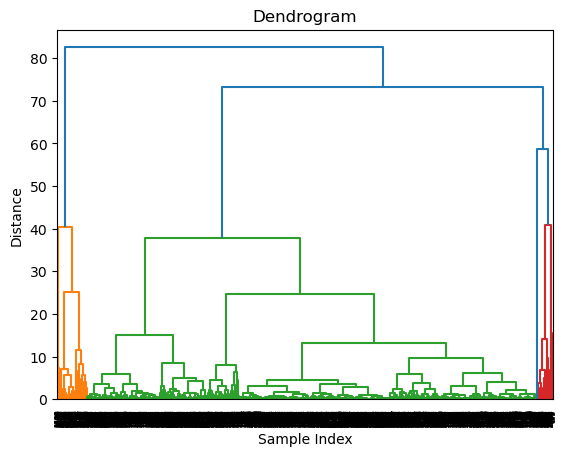

In [10]:
# Perform clustering and show dendrogram
cluster = linkage(features_scaled, method = 'ward')
dendrogram(cluster)
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

The dendrogram created 4 clusters

### Step 3: Set Up Cluster Interpretation

After determining the optimal number of clusters from the dendrogram, we now assign each county to a cluster using the extracted cluster labels.

To better understand the clustering results, we will:
- Define `num_clusters` as the ideal number of clusters based on the dendrogram created above
- Extract cluster assignment attribute from the hierarchical clustering using `fcluster()` with `criterion = "maxclust"`
- Create a new variable `Cluster` in your cleaned dataframe and assign cluster labels to it
- Compute and print the mean values of the original energy potential features for each cluster.

This summary will help us interpret how counties differ in energy potential across clusters and inform possible next steps for analysis.


In [11]:
features_scaled.head()

,utility_pv_technical_generation_potential_mwh,residential_pv_technical_generation_potential_mwh,land_based_wind_technical_generation_potential_mwh,commercial_pv_technical_generation_potential_mwh
0,-0.331171,-0.121811,-0.369593,-0.214820
1,0.638649,0.549126,-0.370021,0.081081
2,-0.004453,-0.270669,-0.266443,-0.199095
3,-0.510007,-0.279806,-0.395868,-0.223600
4,-0.473902,-0.123166,-0.251646,0.007931


In [12]:
# Optimal number of clusters
num_clusters = 4

# Extract cluster assignment attribute
cluster_labels = fcluster(cluster, num_clusters, criterion = "maxclust")

# Add cluster as a new column in data frame
features_scaled['Cluster'] = cluster_labels

# Compute and print mean values
mean_values_per_cluster = features_scaled.groupby('Cluster').mean()
mean_values_per_cluster

,utility_pv_technical_generation_potential_mwh,residential_pv_technical_generation_potential_mwh,land_based_wind_technical_generation_potential_mwh,commercial_pv_technical_generation_potential_mwh
Cluster,,,,
1,2.831068,-0.193351,3.004580,-0.197860
2,-0.184742,-0.121549,-0.185776,-0.104943
3,-0.076363,3.631745,-0.382148,3.046819
4,-0.661236,26.888227,-0.527199,37.606587


### Step 4: Visualizing Energy Potential Across Clusters
Now that we have assigned cluster labels, we want to understand how energy potential differs across clusters. To do this, we will visualize these differences using a grouped bar chart.

Each bar should represent the mean value of an energy potential indicator for a specific cluster. These different patterns of potential is what caused the model to segregate the clusters in the way that it did.

(-5.0, 40.0)

<Figure size 1000x600 with 0 Axes>

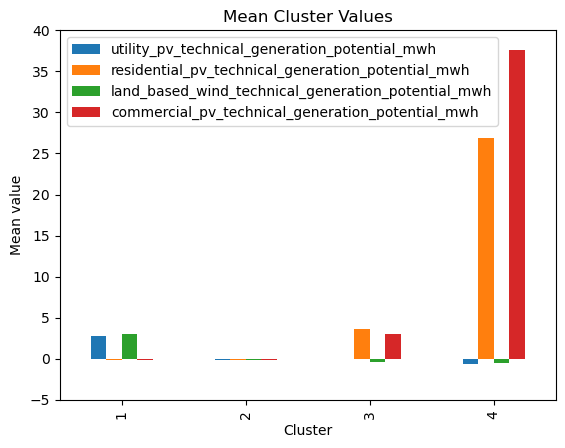

In [13]:
# Bar chart of mean cluster values
plt.figure(figsize=(10, 6))
mean_values_per_cluster.plot(kind = 'bar')
plt.title('Mean Cluster Values')
plt.ylabel('Mean value')
plt.ylim(-5,40)

### Step 5: Interpret Clustering Results
Interpret your plot of the resulting clusters.  How would you characterize and compare the four different clusters in terms of their profile of energy generation?

Cluster 4 is likely a county with a lot of PV potential (sunny!).
The rest of the clusters are likely areas with little wind or solar potential. I find it interesting that cluster 1 is the only cluster with potential for either utility solar or wind, and it makes me wonder if those counties are more rural than 3 and 4. 

## Part II: Environmental Justice Metrics
Now it's your turn.

So far, we have clustered counties based on **energy potential**, but energy potential alone does not tell the full story of **energy equity and access**. To deepen the analysis, we need to consider environmental justice (EJ) factors that affect communities’ ability to benefit from renewable energy and the environmental burdens they already experience.

1. Explore EJSCREEN variables:  
   - The EJSCREEN subset of our dataset contains metrics on pollution burden, demographics (population size), and health risks (*lines 31-41 of the ColumnsExplained tab in the metadata sheet linked above*).
   - Identify 1-3 variables that could be important for energy equity analysis.  You could introduce them either as clustering features, as post-clustering variables to help interpret the clusters, or both. 

2. Modify the clustering approach:  
   - Add your selected EJSCREEN variables to our feature set.    
   - Re-run the hierarchical clustering analysis with the expanded dataset (if you added any as clustering features).  

3. Interpret the Results:
   Your interpretation could include considerations such as:
   - How do clusters change when EJSCREEN variables are included?  
   - Are counties with high renewable energy potential also burdened by environmental risks?  
   - What policy recommendations might emerge from these findings?  

In [14]:
eeip_data.head(5)

,county_fips,county,state,county_pop,utilitypv_techpot_quint,utility_pv_technical_generation_potential_mwh,residentialpv_techpot_quint,residential_pv_technical_generation_potential_mwh,landbasedwind_techpot_quint,land_based_wind_technical_generation_potential_mwh,commercialpv_techpot_quint,commercial_pv_technical_generation_potential_mwh,commercialpv_lcoe_cap_quint,commercial_pv_lcoe_capital_price_per_mw_median,commercialpv_lcoe_quint,commercial_pv_lcoe_price_per_mwh_median,geothermal_lcoe_cap_quint,geothermal_lcoe_capital_price_per_mw_median,geothermal_lcoe_quint,geothermal_lcoe_price_per_mwh_median,hydro_lcoe_cap_quint,hydro_lcoe_capital_price_per_mw_median,hydro_lcoe_quint,hydro_lcoe_price_per_mwh_median,landbasedwind_lcoe_cap_quint,land_based_wind_lcoe_capital_price_per_mw_median,landbasedwind_lcoe_quint,land_based_wind_lcoe_price_per_mwh_median,utilitypv_lcoe_cap_quint,pv_lcoe_capital_price_per_mw_median,utilitypv_lcoe_quint,pv_lcoe_price_per_mwh_median,residentialpv_lcoe_cap_quint,residential_pv_lcoe_capital_price_per_mw_median,residentialpv_lcoe_quint,residential_pv_lcoe_price_per_mwh_median,bev_growth_quint,hev_growth_quint,phev_growth_quint,icev_growth_quint,bev_prop_change,hev_prop_change,phev_prop_change,icev_prop_change,bev_2018_reference_vehicle_counts,bev_2050_reference_vehicle_counts,hev_gasoline_2018_reference_vehicle_counts,hev_gasoline_2050_reference_vehicle_counts,phev_2018_reference_vehicle_counts,phev_2050_reference_vehicle_counts,icev_gasoline_2018_reference_vehicle_counts,icev_gasoline_2050_reference_vehicle_counts,reopt_savings_quint,cost_savings_per_county,energyburden_indicator,energyburden_1_prop,energyburden_2_prop,energyburden_3_prop,energyburden_4_prop,unemployment_quint,unemprate2020,mining_quint,pctempmining,ruralurbancontinuumcode2013,type_2015_farming_no,type_2015_mining_no,population_loss_2015_update,perpov_1980_0711,minority_indicator,minority_pop_1_prop,minority_pop_2_prop,minority_pop_3_prop,minority_pop_4_prop,minority_pop_5_prop,lowincome_indicator,lowincome_pop_1_prop,lowincome_pop_2_prop,lowincome_pop_3_prop,lowincome_pop_4_prop,lowincome_pop_5_prop,lessthanhs_indicator,lessthanhs_pop_1_prop,lessthanhs_pop_2_prop,lessthanhs_pop_3_prop,lessthanhs_pop_4_prop,lessthanhs_pop_5_prop,pm25_indicator,pm25_1_prop,pm25_2_prop,pm25_3_prop,pm25_4_prop,pm25_5_prop,ozone_indicator,ozone_1_prop,ozone_2_prop,ozone_3_prop,ozone_4_prop,ozone_5_prop,leadpaint_indicator,leadpaint_1_prop,leadpaint_2_prop,leadpaint_3_prop,leadpaint_4_prop,leadpaint_5_prop,diesel_indicator,dieselparticulate_1_prop,dieselparticulate_2_prop,dieselparticulate_3_prop,dieselparticulate_4_prop,dieselparticulate_5_prop,cancer_indicator,cancerriskairtoxics_1_prop,cancerriskairtoxics_2_prop,cancerriskairtoxics_3_prop,cancerriskairtoxics_4_prop,cancerriskairtoxics_5_prop,respiratory_indicator,respiratoryhazardairtoxics_1_prop,respiratoryhazardairtoxics_2_prop,respiratoryhazardairtoxics_3_prop,respiratoryhazardairtoxics_4_prop,respiratoryhazardairtoxics_5_prop,traffic_indicator,trafficproxvol_1_prop,trafficproxvol_2_prop,trafficproxvol_3_prop,trafficproxvol_4_prop,trafficproxvol_5_prop,wastewater_indicator,wastewaterdischarge_1_prop,wastewaterdischarge_2_prop,wastewaterdischarge_3_prop,wastewaterdischarge_4_prop,wastewaterdischarge_5_prop,npl_indicator,nplprox_1_prop,nplprox_2_prop,nplprox_3_prop,nplprox_4_prop,nplprox_5_prop,rmp_indicator,rmpprox_1_prop,rmpprox_2_prop,rmpprox_3_prop,rmpprox_4_prop,rmpprox_5_prop,tsdf_indicator,tsdfprox_1_prop,tsdfprox_2_prop,tsdfprox_3_prop,tsdfprox_4_prop,tsdfprox_5_prop
0,1001,Autauga,AL,55200,3,3.585222e+07,4.0,122752.69,3,4374954.41,3.0,72863.02,NaN,NaN,2.0,66.302167,NaN,NaN,NaN,NaN,2.0,6532994.0,1.0,23.0,1.0,1530092.0,5.0,67.0,1.0,1085440.0,3.0,51.0,NaN,NaN,2.0,103.667192,4.0,2.0,2.0,4.0,0.036473,0.026496,0.005495,-0.068464,151.0,2170.0,619.0,2151.0,37.0,343.0,47791.0,50162.0,0,0.000000,0.045833,0.583333,0.333333,0.083333,0.0,1,4.9,3,0.354783,2,0,0,0,0,0.000000,0.000000,0.343750,0.468750,0.187500

Selected EJSCREEN variables that may be important in energy equity analysis:

- `minority_indicator` 
- `pm25_indicator`

Start with trying to include as clustering features

In [15]:
# Add EJSCREEN variables to feature data frame
features2 = eeip_data[[
    'utility_pv_technical_generation_potential_mwh',
    'residential_pv_technical_generation_potential_mwh',
    'land_based_wind_technical_generation_potential_mwh',
    'commercial_pv_technical_generation_potential_mwh',
    'minority_indicator',
    'pm25_indicator'
]]

features2.head()

,utility_pv_technical_generation_potential_mwh,residential_pv_technical_generation_potential_mwh,land_based_wind_technical_generation_potential_mwh,commercial_pv_technical_generation_potential_mwh,minority_indicator,pm25_indicator
0,3.585222e+07,122752.69,4374954.41,72863.02,0.000000,0.643750
1,1.257822e+08,483008.57,4368631.72,361886.15,0.000000,0.000000
2,6.614827e+07,42823.79,5898864.51,88221.80,0.408696,0.669565
3,1.926909e+07,37917.84,3986770.03,64286.62,0.066667,0.000000
4,2.261702e+07,122024.81,6117474.83,290436.00,0.000000,0.257143


In [16]:
# Check for NA
print("Before dropping NA:")
print(*features2.isna().sum())

# Drop columns that only have NA
features2 = features2.dropna()

# Re-check for NA
print("\nAfter dropping NA:")
print(*features2.isna().sum())

Before dropping NA:
0 1 0 1 0 0

After dropping NA:
0 0 0 0 0 0


In [17]:
# Scale features
features2_scaled = pd.DataFrame(scaler.fit_transform(features2), columns = features2.columns)

In [18]:
# Check the shape
print(f"Shape after dropping NA and scaling: {features2_scaled.shape}")

Shape after dropping NA and scaling: (3107, 6)


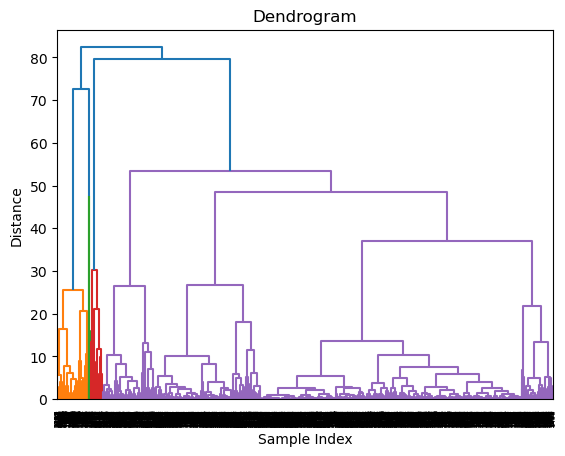

In [19]:
# Re-run hierarchical clustering analysis with expanded dataset
cluster2 = linkage(features2_scaled, method = 'ward')
dendrogram(cluster2)
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [20]:
# Number of clusters
num_clusters2 = 5

# Extract cluster assignment attribute
cluster_labels2 = fcluster(cluster2, num_clusters2, criterion = "maxclust")

# Add cluster as a new column in data frame
features2_scaled['Cluster'] = cluster_labels2

# Compute and print mean values
mean_values_per_cluster2 = features2_scaled.groupby('Cluster').mean()
mean_values_per_cluster2

,utility_pv_technical_generation_potential_mwh,residential_pv_technical_generation_potential_mwh,land_based_wind_technical_generation_potential_mwh,commercial_pv_technical_generation_potential_mwh,minority_indicator,pm25_indicator
Cluster,,,,,,
1,-0.228170,0.388200,-0.310471,0.369047,0.539592,3.623687
2,0.381439,10.858354,-0.243082,9.628364,1.949203,1.613903
3,4.403488,-0.120437,4.490998,-0.187322,1.516708,-0.254453
4,-0.068998,-0.145281,-0.280670,-0.057486,1.869581,-0.257852
5,-0.105558,-0.069395,-0.070513,-0.070418,-0.342492,-0.256945


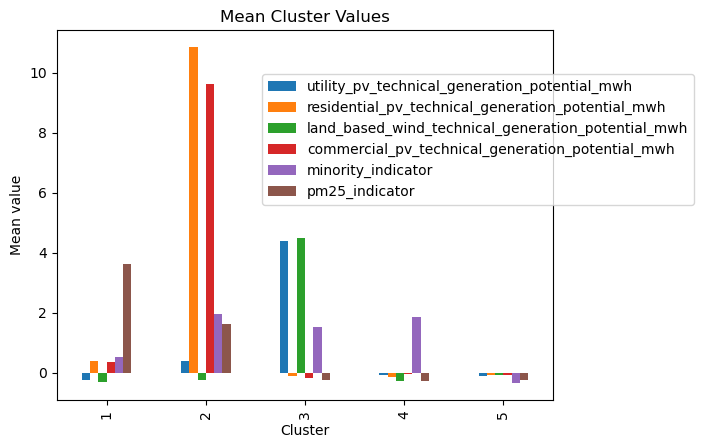

In [22]:
# Visualize potential & EJSCREEN variables across clustersplt
mean_values_per_cluster2.plot(kind = 'bar')
plt.title('Mean Cluster Values')
plt.ylabel('Mean value')
plt.legend(bbox_to_anchor=(0.4, 0.9), loc='upper left')

Which EJSCREEN variable(s) did you add to the analysis? Why did you choose these?  What is the question you are interested in? What did you learn from the analysis

I added `minority_indicator` and `pm25_indicator` to the analysis. I chose minority indicator becuase I was interested to see if areas with high renewable energy potential would have a high population of minorites. I chose PM 2.5 indicator because I was interested to see if areas with high renewable potential also had air quality burdens. I was surprised by cluster 2, as the highest residental and commercial PV potential is grouped with the highest minority indicator, as well as the second highest PM 2.5 indicator! Comparing this to group 4, with the second highest minority indicator, but negative clean energy generation potential, has me wondering what is going on. It is also interesting to see that the cluster with the highest PM 2.5 indicator (cluster 1) has very low clean energy potential.